# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [18]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

Cloning into 'latent-diffusion'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (341/341), 28.69 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (143/143), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Obtaining file:///content/latent-diffusion/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [19]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

/content/latent-diffusion/latent-diffusion
--2025-07-23 07:27:17--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  24.5MB/s    in 77s     

2025-07-23 07:28:35 (22.8 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [ ]:
!nvidia-smi

Sun Apr  3 13:06:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
!pip install git+https://github.com/openai/CLIP.git
!pip install kornia

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m18qi57l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m18qi57l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 109.1 MB/s eta 0:00:00


Load it.

In [26]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [27]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()


Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [29]:
sampler = DDIMSampler(model)
print(sampler)

And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


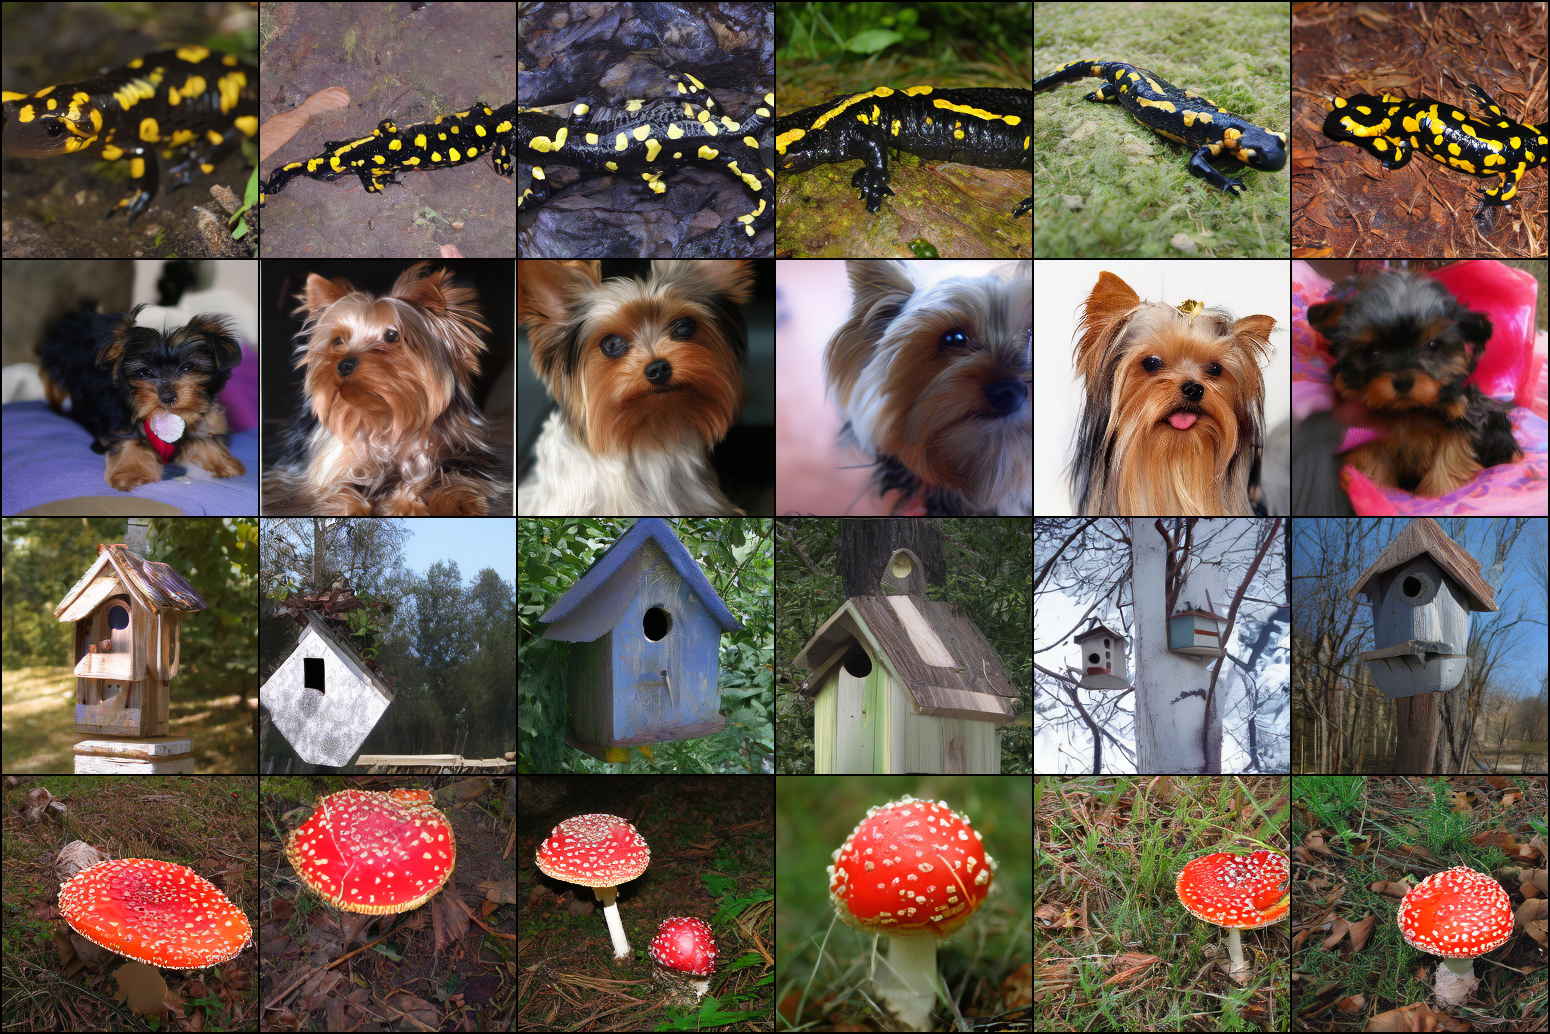

In [30]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )

        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [31]:
!ls

assets	 data		   ldm	    main.py  notebook_helpers.py  scripts
configs  environment.yaml  LICENSE  models   README.md		  setup.py


In [1]:
!wget -nc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
!bash miniconda.sh -b -f -p /usr/local

--2025-07-23 07:56:51--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160039710 (153M) [application/octet-stream]
Saving to: ‘miniconda.sh’

miniconda.sh        100%[===================>] 152.62M   169MB/s    in 0.9s    

2025-07-23 07:56:52 (169 MB/s) - ‘miniconda.sh’ saved [160039710/160039710]

PREFIX=/usr/local
Unpacking payload ...
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.



In [4]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [5]:
!eval "$(/usr/local/bin/conda shell.bash hook)"

In [7]:
!source /usr/local/etc/profile.d/conda.sh && \
 conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main && \
 conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r


In [8]:
!conda create -y -n py385 python=3.8.5

2 channel Terms of Service accepted
Channels:
 - defaults
Platform: linux-64
Solving environment: | done

## Package Plan ##

  environment location: /usr/local/envs/py385

  added / updated specs:
    - python=3.8.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libffi-3.3                 |       he6710b0_2          50 KB
    openssl-1.1.1w             |       h7f8727e_0         3.7 MB
    pip-24.2                   |   py38h06a4308_0         2.2 MB
    python-3.8.5               |       h7579374_1        49.3 MB
    setuptools-75.1.0          |   py38h06a4308_0         1.7 MB
    wheel-0.44.0               |   py38h06a4308_0         108 KB
    ------------------------------------------------------------
                                           Total:        57.1 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  

In [10]:
!source /usr/local/etc/profile.d/conda.sh && conda activate py385 && python --version
!ls

Python 3.8.5
'=1.0.8'   latent-diffusion   sample_data
'=2.0.0'   miniconda.sh       taming-transformers


In [18]:
!cd
!ls        # ← wi


/bin/bash: line 1: cd: latent-fusion: No such file or directory
'=1.0.8'   latent-diffusion   sample_data
'=2.0.0'   miniconda.sh       taming-transformers


In [22]:
%cd latent-diffusion/

/content/latent-diffusion


In [23]:
!ls

'=1.0.8'   data		      LICENSE		    README.md
'=2.0.0'   environment.yaml   main.py		    scripts
 assets    latent-diffusion   models		    setup.py
 configs   ldm		      notebook_helpers.py   taming-transformers


'=1.0.8'   latent-diffusion   sample_data
'=2.0.0'   miniconda.sh       taming-transformers


In [24]:
!conda env create -f environment.yaml
!conda activate ldm

2 channel Terms of Service accepted
Channels:
 - pytorch
 - defaults
Platform: linux-64
Solving environment: - done

pytorch-1.7.0        | 663.0 MB  | :   0% 0/1 [00:00<?, ?it/s]
cudatoolkit-11.0.221 | 622.9 MB  | :   0% 0/1 [00:00<?, ?it/s]

mkl-2021.4.0         | 142.6 MB  | :   0% 0/1 [00:00<?, ?it/s]


torchvision-0.8.1    | 17.9 MB   | :   0% 0/1 [00:00<?, ?it/s]



numpy-base-1.19.2    | 10.1 MB   | :   0% 0/1 [00:00<?, ?it/s]




intel-openmp-2021.4. | 4.2 MB    | :   0% 0/1 [00:00<?, ?it/s]





libgfortran5-11.2.0  | 2.0 MB    | :   0% 0/1 [00:00<?, ?it/s]






pip-20.3.3           | 1.8 MB    | :   0% 0/1 [00:00<?, ?it/s]







libuv-1.48.0         | 950 KB    | :   0% 0/1 [00:00<?, ?it/s]








pillow-10.4.0        | 795 KB    | :   0% 0/1 [00:00<?, ?it/s]









freetype-2.13.3      | 686 KB    | :   0% 0/1 [00:00<?, ?it/s]










libtiff-4.5.1        | 534 KB    | :   0% 0/1 [00:00<?, ?it/s]











libwebp-base-1.3.2   | 425 KB    | :   0% 0/1 [00:00<?, ?it

In [31]:
!source /usr/local/etc/profile.d/conda.sh && conda activate ldm && python --version


Python 3.8.5


In [35]:
!source /usr/local/etc/profile.d/conda.sh && conda activate ldm && pip install einops==0.6.0

     |████████████████████████████████| 41 kB 777 kB/s 
  Attempting uninstall: einops
    Found existing installation: einops 0.3.0
    Uninstalling einops-0.3.0:
      Successfully uninstalled einops-0.3.0


In [38]:
!mkdir -p models/rdm/rdm768x768/
!wget -O models/rdm/rdm768x768/model.ckpt https://ommer-lab.com/files/rdm/model.ckpt

--2025-07-23 08:44:20--  https://ommer-lab.com/files/rdm/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10963025852 (10G)
Saving to: ‘models/rdm/rdm768x768/model.ckpt’

models/rdm/rdm768x7 100%[===================>]  10.21G  22.6MB/s    in 7m 54s  

2025-07-23 08:52:14 (22.1 MB/s) - ‘models/rdm/rdm768x768/model.ckpt’ saved [10963025852/10963025852]



In [40]:
!source /usr/local/etc/profile.d/conda.sh && conda activate ldm && pip install "protobuf<3.21"

     |████████████████████████████████| 1.0 MB 6.4 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [51]:
!nvidia-smi

Wed Jul 23 09:30:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [52]:
!source /usr/local/etc/profile.d/conda.sh && conda activate ldm && python scripts/knn2img.py --prompt "a happy bear reading a newspaper, oil on canvas"

^C


In [57]:
import torch

if torch.cuda.is_available():
   print("✅ CUDA is available")
   print("GPU name:", torch.cuda.get_device_name(0))
   x = torch.randn(10000, 10000).to("cuda")
   y = x @ x.T

✅ CUDA is available
GPU name: Tesla T4


In [59]:
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config


In [61]:
!ls
ckpt = "models/rdm/rdm768x768/model.ckpt"
config_path = "configs/retrieval-augmented-diffusion/768x768.yaml"


'=1.0.8'	    latent-diffusion	        notebook_helpers.py
'=2.0.0'	    latent_diffusion.egg-info   README.md
 assets		    ldm			        scripts
 configs	    LICENSE		        setup.py
 data		    main.py		        src
 environment.yaml   models		        taming-transformers
